<a href="https://colab.research.google.com/github/ulfanuroktaviana575/Image-Retrieval_261_235/blob/main/TUBES_CBIR_2018_261_2018_235.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **TUBES CBIR**

1. Ulfah Nur Oktaviana (201810370311261)
2. Tiara Intana Sari (201810370311235)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import zipfile

In [ ]:
# Definisikan path kaggle json
# Sesuaikan dengan path anda
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/TKC"

In [ ]:
# Ubah lokasi direktori kerja
# Sesuaikan dengan path anda
%cd /content/drive/MyDrive/TKC
!ls -a

/content/drive/MyDrive/TKC
best_model_tuning.h5	  data_nilai.csv      train_model_history_ke1.json
chest_xray		  GatherData	      train_model_ke1.h5
chest_xray_dataset	  .ipynb_checkpoints  train_model_weights_ke1.h5
chest-xray-pneumonia.zip  kaggle.json


In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:29<00:00, 19.7MB/s]
100% 2.29G/2.29G [00:29<00:00, 84.8MB/s]


In [ ]:
# Ekstrak dataset
local_zip = "/content/drive/MyDrive/TKC/chest-xray-pneumonia.zip"
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/drive/MyDrive/TKC/chest_xray_dataset/')
zip_ref.close()

In [ ]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

Number of replicas: 1
2.7.0


**JURNAL REFERENSI**

[Medical image retrieval for detecting pneumonia using binary classification with deep convolutional neural networks](https://www.tandfonline.com/doi/abs/10.1080/02522667.2020.1809096)

jumlah data disesuaikan dengan paper rujukan

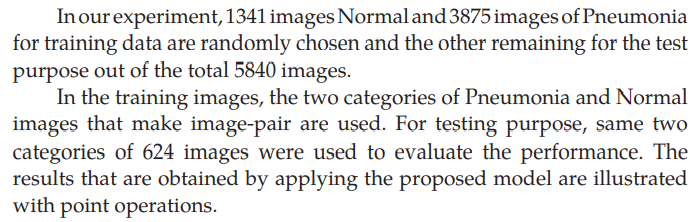

In [ ]:
# Import the required modules
from skimage import img_as_float
from skimage import exposure
import plotly.graph_objects as go

import os
import glob
import random
from skimage import io # To preprocess the images
from distutils.file_util import copy_file
import seaborn as sns
import cv2
import keras
from keras.models import load_model
from keras import backend as K
import tensorflow as tf

from skimage.transform import rescale
from keras_preprocessing.image import ImageDataGenerator

import warnings
warnings.simplefilter('ignore')

In [ ]:
base_dir = '/content/drive/MyDrive/TKC/chest_xray_dataset/'
cls = ['NORMAL', 'PNEUMONIA']

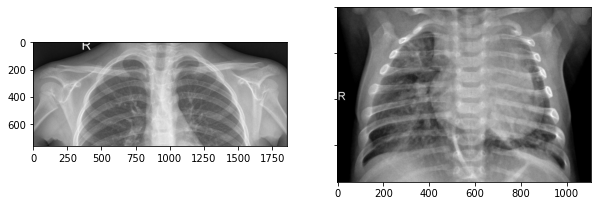

In [ ]:
norm_path = os.path.join(base_dir, cls[0], '*')
norm = glob.glob(norm_path)
norm = io.imread(norm[0])

pneu_path = os.path.join(base_dir, cls[1], '*')
pneu = glob.glob(pneu_path)
pneu = io.imread(pneu[0])

f, axes = plt.subplots(1, 2, sharey=True)
f.set_figwidth(10)

axes[0].imshow(norm, cmap='gray')
axes[1].imshow(pneu, cmap='gray')

In [ ]:
def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf

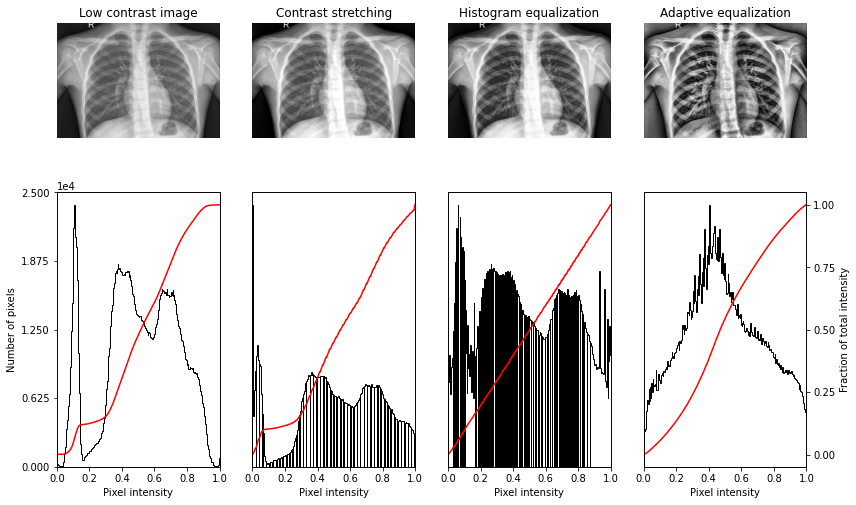

In [ ]:
img = norm

# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

# Display results
fig = plt.figure(figsize=(12, 8))
axes = np.zeros((2, 4), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

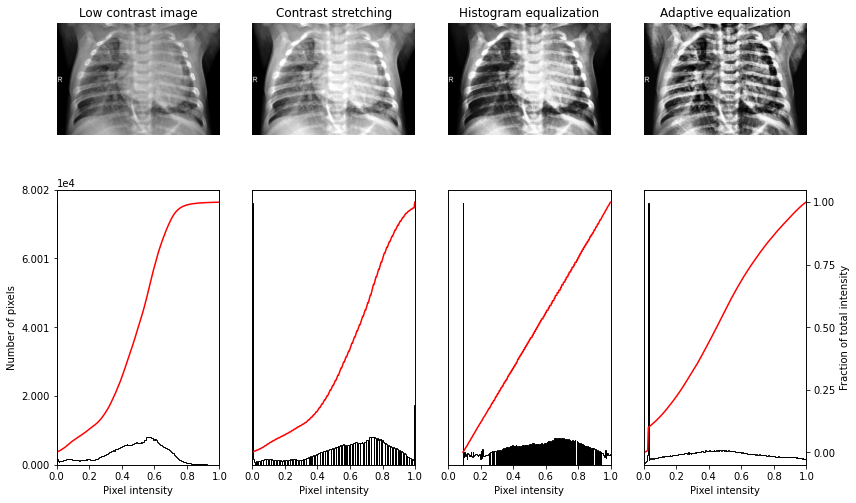

In [ ]:
img = pneu

# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

# Display results
fig = plt.figure(figsize=(12, 8))
axes = np.zeros((2, 4), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

In [ ]:
base_dir = '/content/drive/MyDrive/TKC/chest_xray'

train_dir = os.path.join(base_dir, 'train')
norm_train_dir = os.path.join(train_dir, 'NORMAL')
pneu_train_dir = os.path.join(train_dir, 'PNEUMONIA')

val_dir = os.path.join(base_dir, 'test')
norm_val_dir = os.path.join(val_dir, 'NORMAL')
pneu_val_dir = os.path.join(val_dir, 'PNEUMONIA')

In [ ]:
print("Total Training NORMAL:", len(os.listdir(norm_train_dir)))
print("Total Training PNEUMONIA:", len(os.listdir(pneu_train_dir)))
print()
print("Total validation NORMAL:", len(os.listdir(norm_val_dir)))
print("Total validation PNEUMONIA:", len(os.listdir(pneu_val_dir)))

Total Training NORMAL: 1341
Total Training PNEUMONIA: 3875

Total validation NORMAL: 234
Total validation PNEUMONIA: 390


In [ ]:
def gather_data(data_dir):
    dir_data = []
    dir_label = []

    for dirpath, dirnames, filenames in os.walk(data_dir):
        for file in filenames:
            if ".jpeg" in file:
                image_path = os.path.join(dirpath, file)

                image = cv2.imread(image_path)
                image = cv2.resize(image, (150,150))
                image = image.astype('float32') / 255.0
                dir_data.append(image)

                label = int((image_path.split(os.path.sep)[-2]) == 'PNEUMONIA')
                dir_label.append(label)

    dir_data = np.array(dir_data)
    dir_label = np.array(dir_label)

    return dir_data, dir_label

In [ ]:
x_train, y_train = gather_data(train_dir)
x_val, y_val = gather_data(val_dir)

In [ ]:
gather_save = '/content/drive/MyDrive/TKC/GatherData'

In [ ]:
preprocessed_data = [x_train, y_train, x_val, y_val]
preprocessed_file_name = ['x_train', 'y_train', 'x_val', 'y_val']
for i, file_name in enumerate(preprocessed_file_name):
    np.save(gather_save + '/' + file_name + '.npy', preprocessed_data[i])

In [ ]:
import numpy as np

In [ ]:
x_train = np.load(gather_save + '/x_train.npy')
y_train = np.load(gather_save + '/y_train.npy')

x_val = np.load(gather_save + '/x_val.npy')
y_val = np.load(gather_save + '/y_val.npy')

In [ ]:
print("Train Data = ", x_train.shape)
print("Train Label = ", y_train.shape)
print()
print("Val Data = ", x_val.shape)
print("Val Label = ", y_val.shape)

Train Data =  (5216, 150, 150, 3)
Train Label =  (5216,)

Val Data =  (624, 150, 150, 3)
Val Label =  (624,)


In [ ]:
from skimage.io import imread
from skimage.transform import resize

In [ ]:
def conv_block(filters):
    block = Sequential([
        SeparableConv2D(filters, 3, activation='relu', padding='same'),
        SeparableConv2D(filters, 3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D()
    ])
    
    return block

In [ ]:
def dense_block(units, dropout_rate):
    block = Sequential([
        Dense(units, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate)
    ])
    
    return block

In [ ]:
def build_model():
    model = Sequential([
        Input(shape=(150, 150, 3)),

        Conv2D(16, 3, activation='relu', padding='same'),
        Conv2D(16, 3, activation='relu', padding='same'),
        MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        conv_block(128),
        
        Dropout(0.2),
        
        conv_block(256),
        
        Dropout(0.2),
        Flatten(),
        
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        Dense(1, activation='sigmoid')
    ])
    
    return model

In [ ]:
base_dir = '/content/drive/MyDrive/TKC/chest_xray_dataset/'

In [ ]:
norm_dir = os.path.join(base_dir, 'NORMAL')
pneu_dir = os.path.join(base_dir, 'PNEUMONIA')

print("Total Training NORMAL:", len(os.listdir(norm_dir)))
print("Total Training PNEUMONIA:", len(os.listdir(pneu_dir)))

Total Training NORMAL: 1575
Total Training PNEUMONIA: 4265


In [ ]:
norm_data_count = len(os.listdir(norm_dir))
pneu_data_count = len(os.listdir(pneu_dir))

print(f"Jumlah Normal: {norm_data_count}\nJumlah Pneoumonia: {pneu_data_count}")

Jumlah Normal: 1575
Jumlah Pneoumonia: 4265


In [ ]:
weight_for_0 = (1 / norm_data_count) * (x_train.shape[0]) / 2.0 
weight_for_1 = (1 / pneu_data_count) * (x_train.shape[0]) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.66
Weight for class 1: 0.61


In [ ]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense, Dropout, Flatten, InputLayer, MaxPool2D, SeparableConv2D
from tensorflow.keras.metrics import Precision, Recall

In [ ]:
model = build_model()

METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
]
    
model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
)

In [ ]:
BATCH_SIZE = 128
EPOCH = 25

In [ ]:
TRAIN_IMG_COUNT = x_train.shape[0]
VAL_IMG_COUNT = x_val.shape[0]

In [ ]:
history = model.fit(x_train, y_train,
              steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
              epochs=EPOCH,
              validation_data=(x_val, y_val),
              validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
              class_weight=class_weight,
              )

Epoch 1/25
40/40 [==============================] - 196s 5s/step - loss: 0.3934 - accuracy: 0.7625 - precision: 0.9621 - recall: 0.7081 - val_loss: 0.6718 - val_accuracy: 0.6250 - val_precision: 0.6250 - val_recall: 1.0000
Epoch 2/25
40/40 [==============================] - 192s 5s/step - loss: 0.2199 - accuracy: 0.8969 - precision: 0.9793 - recall: 0.8797 - val_loss: 0.7723 - val_accuracy: 0.6250 - val_precision: 0.6250 - val_recall: 1.0000
Epoch 3/25
40/40 [==============================] - 192s 5s/step - loss: 0.1407 - accuracy: 0.9448 - precision: 0.9867 - recall: 0.9383 - val_loss: 0.9935 - val_accuracy: 0.6250 - val_precision: 0.6250 - val_recall: 1.0000
Epoch 4/25
40/40 [==============================] - 191s 5s/step - loss: 0.1185 - accuracy: 0.9532 - precision: 0.9845 - recall: 0.9520 - val_loss: 1.1930 - val_accuracy: 0.6250 - val_precision: 0.6250 - val_recall: 1.0000
Epoch 5/25
40/40 [==============================] - 191s 5s/step - loss: 0.0992 - accuracy: 0.9594 - precisi

In [ ]:
import json
target_dir = '/content/drive/MyDrive/TKC'

In [ ]:
history_dict = history.history
json.dump(history_dict, open(target_dir + '/train_model_history_ke1.json', 'w'))

model.save(target_dir + '/train_model_ke1.h5')
model.save_weights(target_dir + '/train_model_weights_ke1.h5')

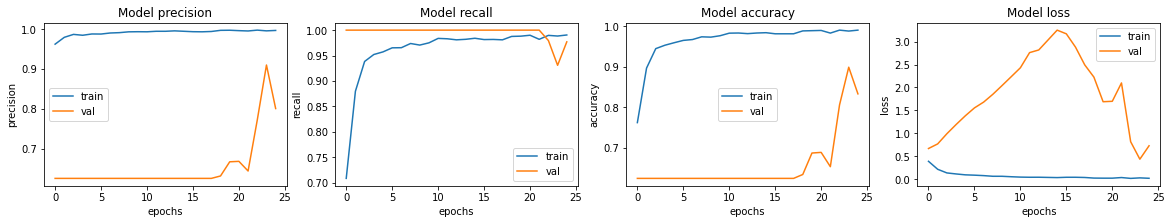

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
save_dir = target_dir

checkpoint_cb = ModelCheckpoint(save_dir + "/best_model_tuning.h5",
                                save_best_only=True)

early_stopping_cb = EarlyStopping(patience=25,
                                  restore_best_weights=True)

In [ ]:
# from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
# def exponential_decay(lr0, s):
#     def exponential_decay_fn(epoch):
#         return lr0 * 0.1 **(epoch / s)
#     return exponential_decay_fn

# exponential_decay_fn = exponential_decay(0.01, 20)

# lr_scheduler = LearningRateScheduler(exponential_decay_fn)

In [ ]:
EPOCH = 100

In [ ]:
history = model.fit(x_train, y_train,
              steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
              epochs=EPOCH,
              validation_data=(x_val, y_val),
              validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
              class_weight=class_weight,
              callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
              )

Epoch 1/100
40/40 [==============================] - 220s 5s/step - loss: 0.0500 - accuracy: 0.9776 - precision: 0.9932 - recall: 0.9765 - val_loss: 1.0511 - val_accuracy: 0.7340 - val_precision: 0.7022 - val_recall: 0.9974
Epoch 2/100
40/40 [==============================] - 220s 6s/step - loss: 0.0377 - accuracy: 0.9835 - precision: 0.9950 - recall: 0.9827 - val_loss: 0.7851 - val_accuracy: 0.8189 - val_precision: 0.7787 - val_recall: 0.9923
Epoch 3/100
40/40 [==============================] - 220s 5s/step - loss: 0.0440 - accuracy: 0.9812 - precision: 0.9948 - recall: 0.9799 - val_loss: 0.6918 - val_accuracy: 0.8285 - val_precision: 0.7894 - val_recall: 0.9897
Epoch 4/100
40/40 [==============================] - 219s 5s/step - loss: 0.0329 - accuracy: 0.9866 - precision: 0.9951 - recall: 0.9868 - val_loss: 1.7888 - val_accuracy: 0.6891 - val_precision: 0.6678 - val_recall: 1.0000
Epoch 5/100
40/40 [==============================] - 221s 6s/step - loss: 0.0310 - accuracy: 0.9866 - pr

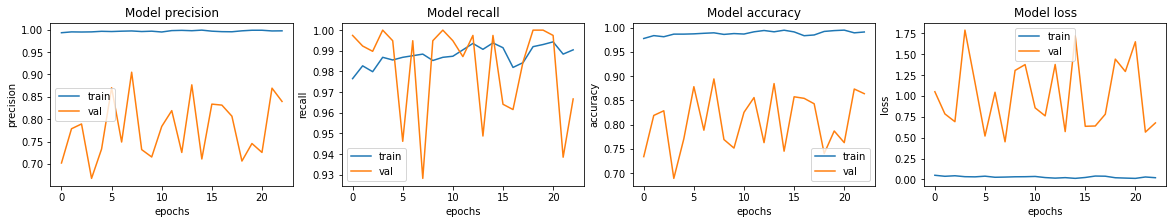

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
model = load_model(target_dir + '/train_model_ke1.h5')

In [ ]:
loss, acc, prec, rec = model.evaluate(x_val, y_val)
print(f"Accuracy = {acc * 100:.2f} %")
print(f"Precision = {prec * 100:.2f} %")
print(f"Recall = {rec * 100:.2f} %")

20/20 [==============================] - 7s 314ms/step - loss: 0.7316 - accuracy: 0.8333 - precision: 0.8004 - recall: 0.9769
Accuracy = 83.33 %
Precision = 80.04 %
Recall = 97.69 %


In [ ]:
model = load_model(target_dir + '/best_model_tuning.h5')

In [ ]:
#train
loss, acc, prec, rec = model.evaluate(x_train, y_train)
print(f"Accuracy = {acc * 100:.2f} %")
print(f"Precision = {prec * 100:.2f} %")
print(f"Recall = {rec * 100:.2f} %")

163/163 [==============================] - 54s 326ms/step - loss: 0.0336 - accuracy: 0.9858 - precision: 1.0000 - recall: 0.9809
Accuracy = 98.58 %
Precision = 100.00 %
Recall = 98.09 %


In [ ]:
#test
loss, acc, prec, rec = model.evaluate(x_val, y_val)
print(f"Accuracy = {acc * 100:.2f} %")
print(f"Precision = {prec * 100:.2f} %")
print(f"Recall = {rec * 100:.2f} %")

20/20 [==============================] - 7s 351ms/step - loss: 0.4507 - accuracy: 0.8942 - precision: 0.9050 - recall: 0.9282
Accuracy = 89.42 %
Precision = 90.50 %
Recall = 92.82 %
